# Notes

## Target:
- Model architecture with skip connections
- dropout as 3%
  
## Result:
- train accuracy: 91.6%
- test accuracy: 89% in 40 epochs

## Analysis:
- modify the probability values in data augmentation
- learning rate schedule using OnecycleLR

# Update
## Target
- Ideal p values for steps inside data augmentation
- find min and max lr for 1cycle LR
- weight decay in the loss function

## Result:
- train accuracy: 94%
- test accuracy: 90.33%

## Analysis:
- 1 cycle learning rate schedules helps us train model faster


# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Dataset and Creating Train/Test Split

In [2]:
from data_loader import prepare_cifar_dataloader,\
    RAW_DATA_MEAN, NORM_DATA_MEAN, NORM_DATA_STD
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck']
train_loader, test_loader = prepare_cifar_dataloader()

/opt/homebrew/Caskroom/miniforge/base/envs/torch-gpu/lib/python3.8/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


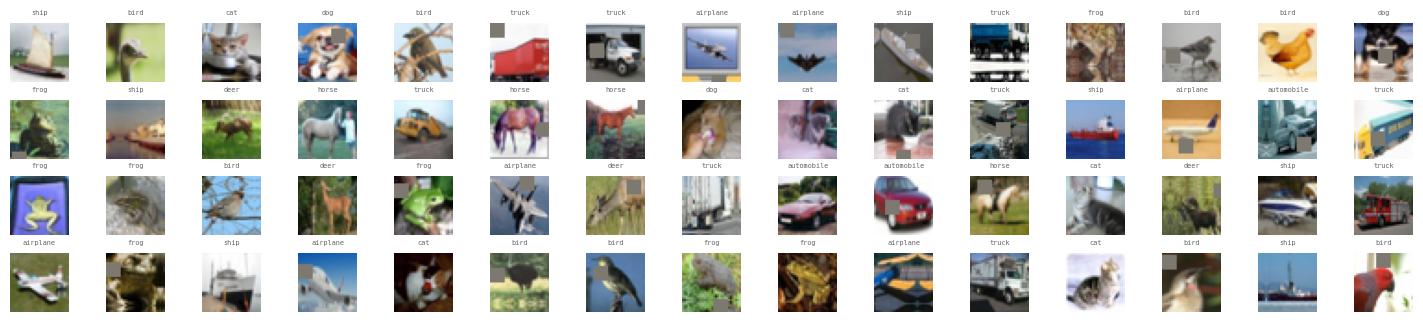

In [3]:
import numpy as np
import utils

utils.plot_img_batch(train_loader, class_labels, ncols=15, nrows=4)

In [4]:
from torchsummary import summary
from tqdm import tqdm
import model

network = model.Net(p=0.03).to('cpu')
summary(network, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
           Dropout-4           [-1, 64, 32, 32]               0
         ConvLayer-5           [-1, 64, 32, 32]               0
            Conv2d-6          [-1, 128, 32, 32]          73,728
         MaxPool2d-7          [-1, 128, 16, 16]               0
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
          Dropout-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
             ReLU-12          [-1, 128, 16, 16]               0
      BatchNorm2d-13          [-1, 128, 16, 16]             256
          Dropout-14          [-1, 128,

/opt/homebrew/Caskroom/miniforge/base/envs/torch-gpu/lib/python3.8/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
from torch import optim
from torchvision import datasets
from torch.optim.lr_scheduler import StepLR, OneCycleLR
from model import train, test, plot_loss_n_acc, get_pred_n_actuals
from utils import plot_misclassified_images

device = 'mps:0'
epochs = 24
network.to(device)
optimizer = optim.Adam(network.parameters(), lr=0.001, weight_decay=1e-4)

In [6]:
# importlib.reload(model)

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.57E-03


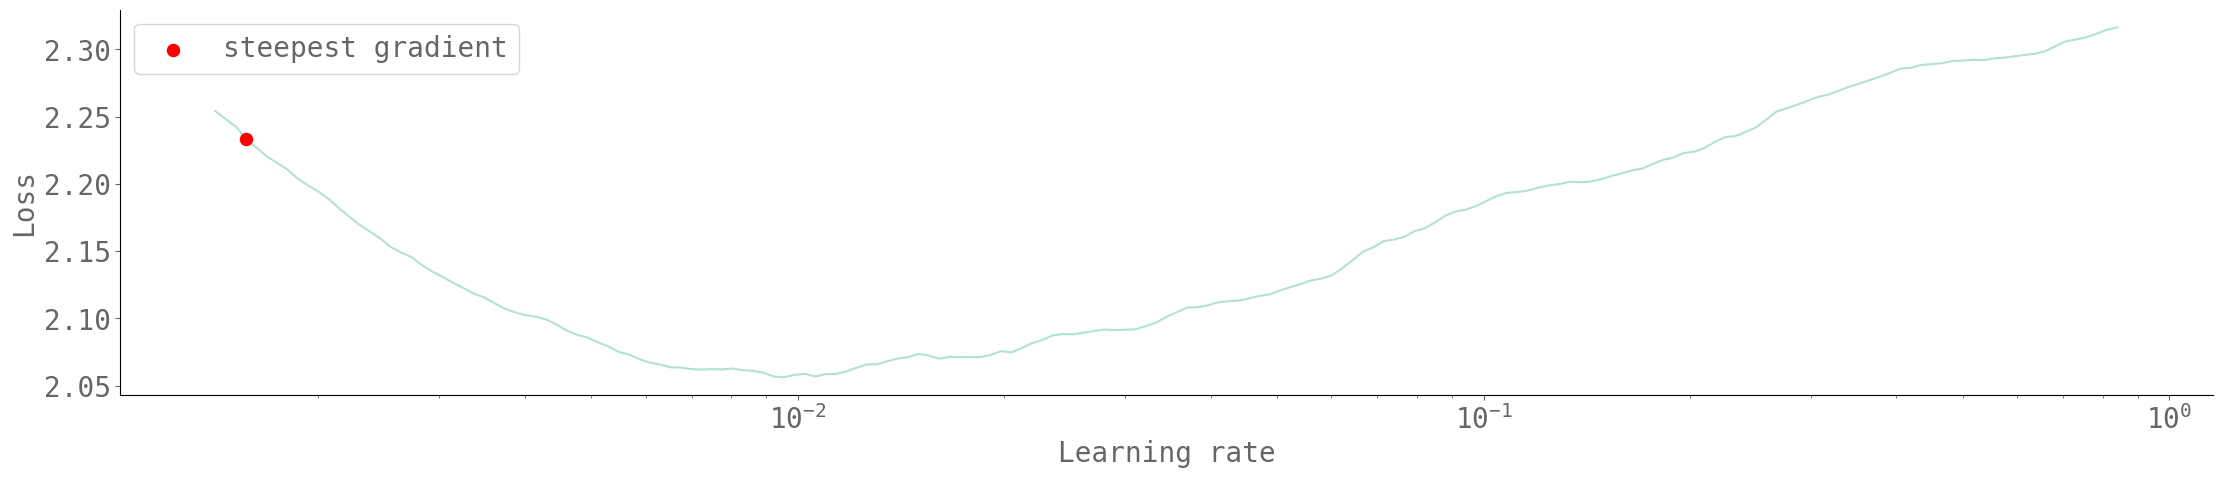

CPU times: user 10.8 s, sys: 2.5 s, total: 13.3 s
Wall time: 2min 16s


In [7]:
%%time
criterion = nn.CrossEntropyLoss()
model.lr_finder(network, optimizer, criterion, device, train_loader)

In [8]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [9]:
scheduler = OneCycleLR(
    optimizer, max_lr=1.57E-03,
    steps_per_epoch=len(train_loader),
    epochs=epochs, 
    pct_start=5/epochs, 
    three_phase=False,
    div_factor=100,
    final_div_factor=100,
    anneal_strategy='linear',
)

# Model training

EPOCH: 0


Loss=2.0034 Batch_id=97 LR=0.00033 Accuracy=34.94: 100%|████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.74it/s]
Test Loss=39.5742 Batch_id=19 Accuracy=48.33: 100%|█████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.14s/it]


Test set: Average loss: 0.0040, Accuracy: 4833/10000 (48.33%)

EPOCH: 1


Loss=1.9455 Batch_id=97 LR=0.00064 Accuracy=51.66: 100%|████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.74it/s]
Test Loss=38.2206 Batch_id=19 Accuracy=55.22: 100%|█████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.15s/it]


Test set: Average loss: 0.0038, Accuracy: 5522/10000 (55.22%)

EPOCH: 2


Loss=1.8121 Batch_id=97 LR=0.00095 Accuracy=62.14: 100%|████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.74it/s]
Test Loss=36.0444 Batch_id=19 Accuracy=66.21: 100%|█████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.15s/it]


Test set: Average loss: 0.0036, Accuracy: 6621/10000 (66.21%)

EPOCH: 3


Loss=1.7850 Batch_id=97 LR=0.00126 Accuracy=68.94: 100%|████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.75it/s]
Test Loss=34.8299 Batch_id=19 Accuracy=72.27: 100%|█████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.15s/it]


Test set: Average loss: 0.0035, Accuracy: 7227/10000 (72.27%)

EPOCH: 4


Loss=1.7219 Batch_id=97 LR=0.00157 Accuracy=72.51: 100%|████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.75it/s]
Test Loss=34.8180 Batch_id=19 Accuracy=72.04: 100%|█████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.15s/it]


Test set: Average loss: 0.0035, Accuracy: 7204/10000 (72.04%)

EPOCH: 5


Loss=1.6985 Batch_id=97 LR=0.00149 Accuracy=74.82: 100%|████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.75it/s]
Test Loss=34.3415 Batch_id=19 Accuracy=74.54: 100%|█████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.15s/it]


Test set: Average loss: 0.0034, Accuracy: 7454/10000 (74.54%)

EPOCH: 6


Loss=1.6741 Batch_id=97 LR=0.00140 Accuracy=78.01: 100%|████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.74it/s]
Test Loss=33.4022 Batch_id=19 Accuracy=79.02: 100%|█████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.15s/it]


Test set: Average loss: 0.0033, Accuracy: 7902/10000 (79.02%)

EPOCH: 7


Loss=1.6343 Batch_id=97 LR=0.00132 Accuracy=79.90: 100%|████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.75it/s]
Test Loss=33.1384 Batch_id=19 Accuracy=80.71: 100%|█████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.15s/it]


Test set: Average loss: 0.0033, Accuracy: 8071/10000 (80.71%)

EPOCH: 8


Loss=1.6049 Batch_id=97 LR=0.00124 Accuracy=81.75: 100%|████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.74it/s]
Test Loss=32.9913 Batch_id=19 Accuracy=81.39: 100%|█████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.14s/it]


Test set: Average loss: 0.0033, Accuracy: 8139/10000 (81.39%)

EPOCH: 9


Loss=1.6380 Batch_id=97 LR=0.00116 Accuracy=82.70: 100%|████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.75it/s]
Test Loss=32.7285 Batch_id=19 Accuracy=82.69: 100%|█████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.15s/it]


Test set: Average loss: 0.0033, Accuracy: 8269/10000 (82.69%)

EPOCH: 10


Loss=1.6291 Batch_id=97 LR=0.00107 Accuracy=84.16: 100%|████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.75it/s]
Test Loss=32.4345 Batch_id=19 Accuracy=83.99: 100%|█████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.15s/it]


Test set: Average loss: 0.0032, Accuracy: 8399/10000 (83.99%)

EPOCH: 11


Loss=1.6222 Batch_id=97 LR=0.00099 Accuracy=85.20: 100%|████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.75it/s]
Test Loss=32.3548 Batch_id=19 Accuracy=84.38: 100%|█████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.15s/it]


Test set: Average loss: 0.0032, Accuracy: 8438/10000 (84.38%)

EPOCH: 12


Loss=1.6171 Batch_id=97 LR=0.00091 Accuracy=86.01: 100%|████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.75it/s]
Test Loss=32.4019 Batch_id=19 Accuracy=84.10: 100%|█████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.15s/it]


Test set: Average loss: 0.0032, Accuracy: 8410/10000 (84.10%)

EPOCH: 13


Loss=1.5702 Batch_id=97 LR=0.00083 Accuracy=86.67: 100%|████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.73it/s]
Test Loss=32.2254 Batch_id=19 Accuracy=85.09: 100%|█████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.16s/it]


Test set: Average loss: 0.0032, Accuracy: 8509/10000 (85.09%)

EPOCH: 14


Loss=1.5822 Batch_id=97 LR=0.00074 Accuracy=87.78: 100%|████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.75it/s]
Test Loss=31.9407 Batch_id=19 Accuracy=86.68: 100%|█████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.14s/it]


Test set: Average loss: 0.0032, Accuracy: 8668/10000 (86.68%)

EPOCH: 15


Loss=1.5856 Batch_id=97 LR=0.00066 Accuracy=88.83: 100%|████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.74it/s]
Test Loss=31.9462 Batch_id=19 Accuracy=86.62: 100%|█████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.15s/it]


Test set: Average loss: 0.0032, Accuracy: 8662/10000 (86.62%)

EPOCH: 16


Loss=1.5786 Batch_id=97 LR=0.00058 Accuracy=89.39: 100%|████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.75it/s]
Test Loss=31.7725 Batch_id=19 Accuracy=87.31: 100%|█████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.16s/it]


Test set: Average loss: 0.0032, Accuracy: 8731/10000 (87.31%)

EPOCH: 17


Loss=1.5527 Batch_id=97 LR=0.00050 Accuracy=90.26: 100%|████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.74it/s]
Test Loss=31.5882 Batch_id=19 Accuracy=88.25: 100%|█████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.16s/it]


Test set: Average loss: 0.0032, Accuracy: 8825/10000 (88.25%)

EPOCH: 18


Loss=1.5514 Batch_id=97 LR=0.00041 Accuracy=90.81: 100%|████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.75it/s]
Test Loss=31.4778 Batch_id=19 Accuracy=88.88: 100%|█████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.14s/it]


Test set: Average loss: 0.0031, Accuracy: 8888/10000 (88.88%)

EPOCH: 19


Loss=1.5357 Batch_id=97 LR=0.00033 Accuracy=91.77: 100%|████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.75it/s]
Test Loss=31.4245 Batch_id=19 Accuracy=88.94: 100%|█████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.16s/it]


Test set: Average loss: 0.0031, Accuracy: 8894/10000 (88.94%)

EPOCH: 20


Loss=1.5442 Batch_id=97 LR=0.00025 Accuracy=92.42: 100%|████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.75it/s]
Test Loss=31.3437 Batch_id=19 Accuracy=89.49: 100%|█████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.15s/it]


Test set: Average loss: 0.0031, Accuracy: 8949/10000 (89.49%)

EPOCH: 21


Loss=1.5378 Batch_id=97 LR=0.00016 Accuracy=92.86: 100%|████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.75it/s]
Test Loss=31.2961 Batch_id=19 Accuracy=89.76: 100%|█████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.15s/it]


Test set: Average loss: 0.0031, Accuracy: 8976/10000 (89.76%)

EPOCH: 22


Loss=1.5253 Batch_id=97 LR=0.00008 Accuracy=93.45: 100%|████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.74it/s]
Test Loss=31.2132 Batch_id=19 Accuracy=90.23: 100%|█████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.17s/it]


Test set: Average loss: 0.0031, Accuracy: 9023/10000 (90.23%)

EPOCH: 23


Loss=1.5193 Batch_id=97 LR=-0.00000 Accuracy=93.99: 100%|███████████████████████████████████████████████| 98/98 [00:56<00:00,  1.73it/s]
Test Loss=31.1866 Batch_id=19 Accuracy=90.33: 100%|█████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]


Test set: Average loss: 0.0031, Accuracy: 9033/10000 (90.33%)



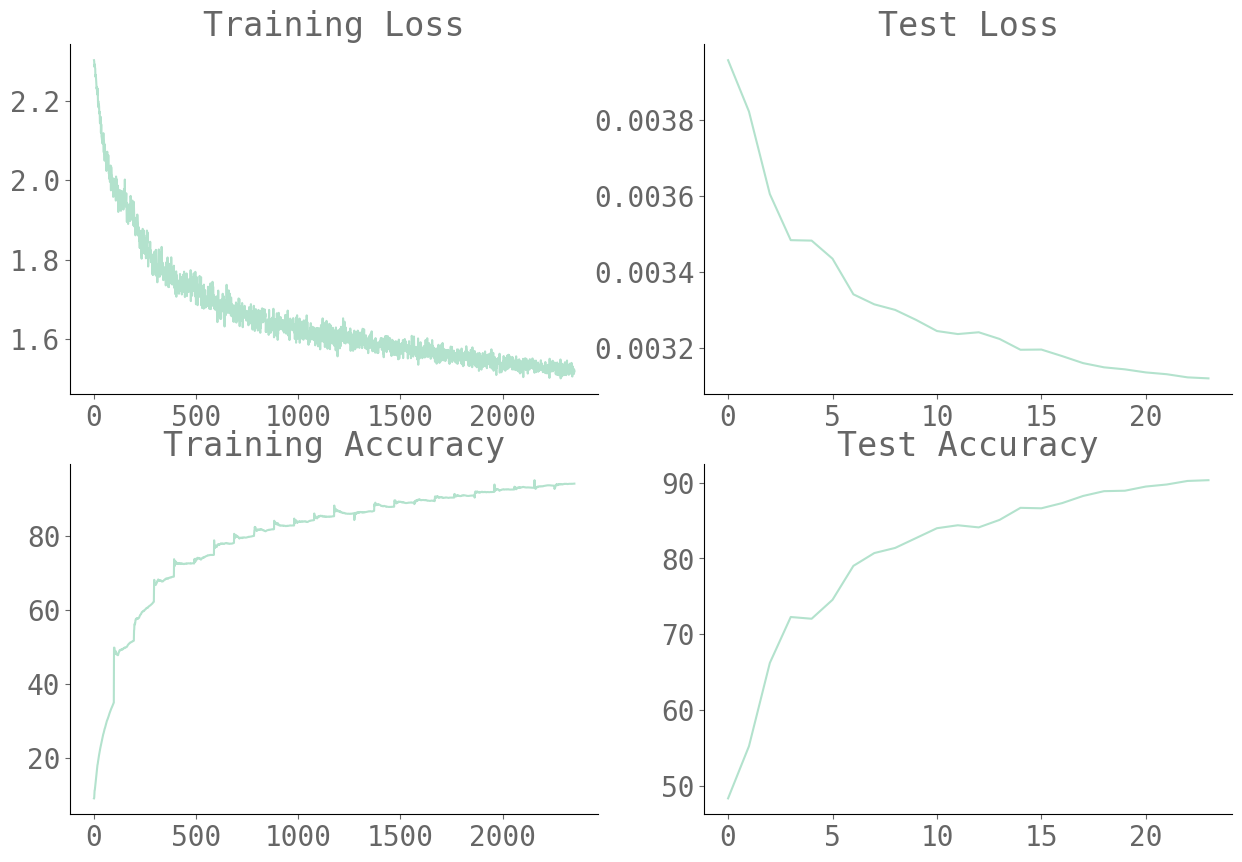

In [11]:
for epoch in range(epochs):
    print("EPOCH:", epoch)
    model.train(network, device, train_loader, optimizer, scheduler)
    test_acc = model.test(network, device, test_loader)

plot_loss_n_acc()

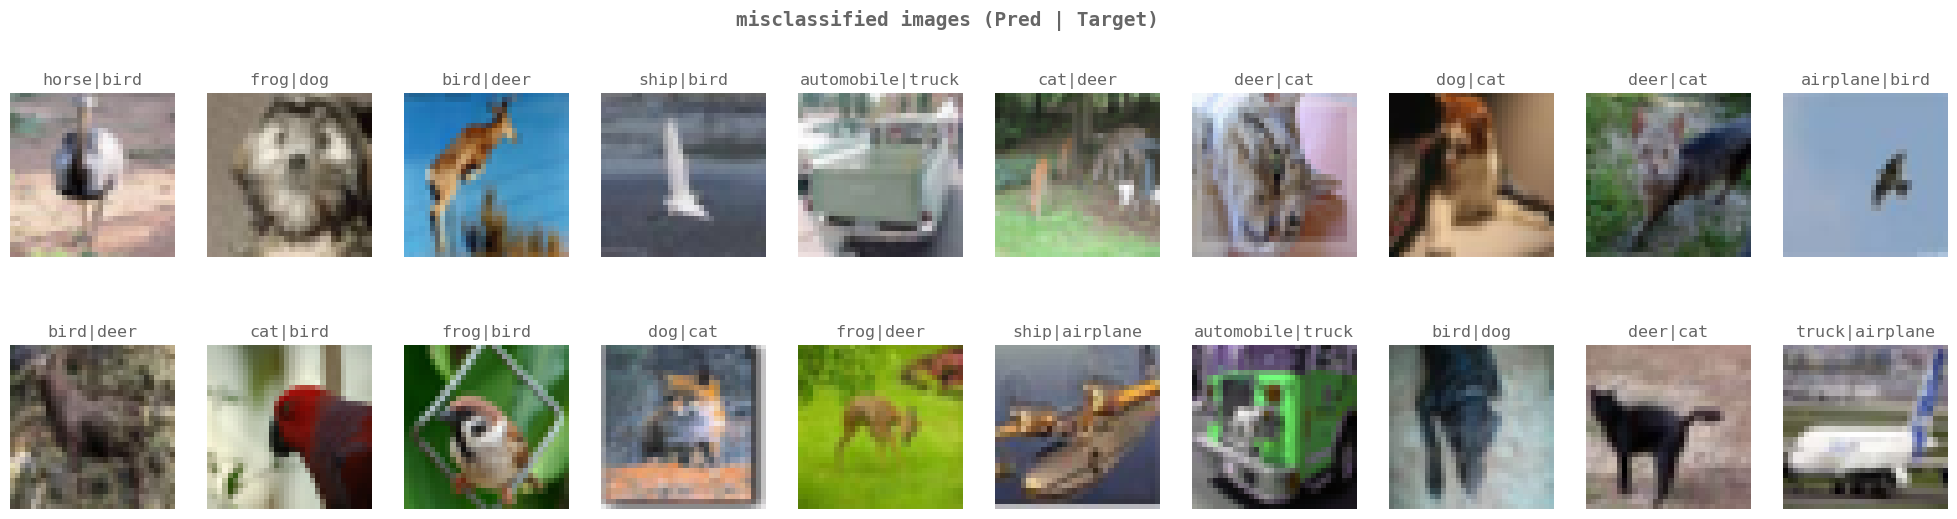

In [21]:
device='mps:0'
labels_df = get_pred_n_actuals(network, test_loader, device)
plot_misclassified_images(labels_df, test_loader.dataset, 
        class_labels, n_samples=20,
        nrows=2, ncols=10, figsize=(25,6),
        title='misclassified images (Pred | Target)', )

Accuracy for class: airplane is 93.3 %
Accuracy for class: automobile is 96.4 %
Accuracy for class: bird  is 84.2 %
Accuracy for class: cat   is 78.6 %
Accuracy for class: deer  is 89.7 %
Accuracy for class: dog   is 85.9 %
Accuracy for class: frog  is 93.9 %
Accuracy for class: horse is 94.2 %
Accuracy for class: ship  is 94.4 %
Accuracy for class: truck is 92.7 %


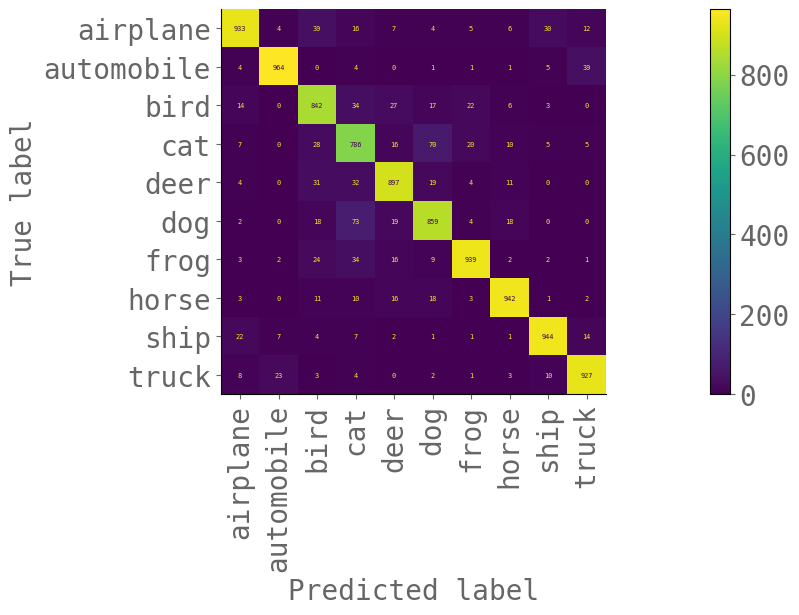

In [23]:
from metrics import get_metrics
get_metrics(labels_df, class_labels)

# Notes

 - with less droupout  (3%) model gets saturated at 82% very quickly
 - with high droupout (10%) model gets diverged, find_lr shows a linear line
 - cutout ratio - 50% and randomcrop at 30%, achieves 85.7%
 - If randomcrop is increased to 100%, the lr_finder shows the linear line
 - same linear line with 50% randomcrop didn't even reach 80%
 - with reduction in number of channels inside Residual connections gets to 86
 - scheduler.step() has to be done after every batch; otherwise wouldn't even reach the max at the end of 24 epoches